In [4]:
# -*- coding: utf-8 -*-
"""
Created on Sun Oct 16 00:33:01 2022

@author: Tracy Zhou
"""

#pip install pydot

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pydot
from sklearn import tree

%matplotlib inline

In [55]:
# input data

df = pd.read_csv("rf_bond.csv",index_col = 0)
X = df.drop('leverage', axis=1)
y = df['leverage']
df.head()

,offer_amt,mat_stated,mat_actual,prot,prot_r,elim,elim_r,coupon,yield,covenant,rating,leverage
1,9642,12.024641,2.110883,2.026010,0.168488,9.913758,0.824454,7.55,7.550,0,6,1
2,13176,15.025325,3.520876,3.025325,0.201348,11.504449,0.765671,7.75,7.750,0,6,1
3,5000,15.058179,3.058179,3.058179,0.203091,12.000000,0.796909,8.00,8.000,0,6,1
4,10000,15.058179,3.058179,3.058179,0.203091,12.000000,0.796909,8.25,8.428,0,6,1
5,2261,4.941821,2.110883,1.941136,0.392798,2.830938,0.572853,8.25,8.250,0,12,1


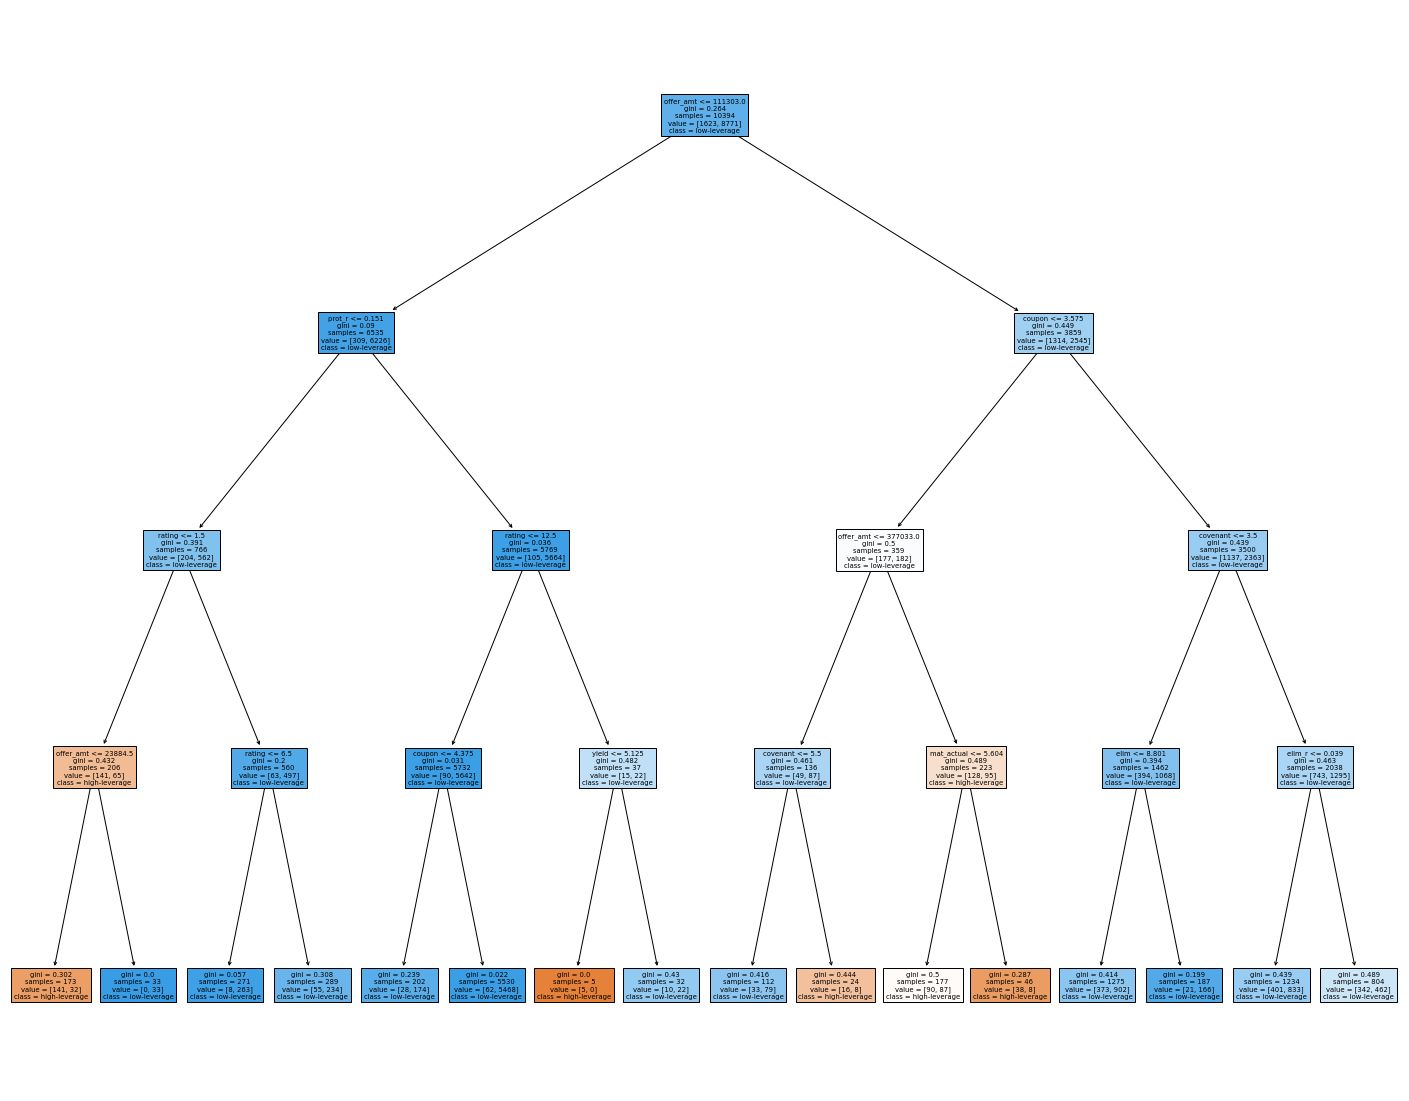

In [56]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, max_depth = 4)
clf.fit(X, y)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=df.columns,  
                   class_names=["high-leverage", "low-leverage"],
                   filled=True)
fig.savefig("plot_Decision_Tree_bond.png", dpi=600, transparent=True)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.33, # ratio of data that is used for testing
    random_state=42,
    stratify = y # Keeps the ratio of the labels in train and test the same as in the initial data
)

import math
n_feature = len(df.columns)
rf = RandomForestClassifier(
    max_features=math.ceil(n_feature**0.5), # Number of randomly picked features for split 
    random_state=42, # Seed for random number generator
    oob_score=True, # Out of Bag accuracy score
    bootstrap=True # 
)
param_grid = {
    'max_depth': np.arange(3,7, 1),
    'n_estimators': [50, 100, 150, 200, 250],
    'max_features': np.arange(3,n_feature,3)
}
grid_search = GridSearchCV(
    estimator=rf, # RandomForestClassifier to be optimized
    param_grid=param_grid, # parameter grid
    cv=4, # cross validation split
    n_jobs=-1, # setting for parallization, -1: use all processors
    verbose=1,
    refit=True # Refit estimator using best found parameters
)
grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
# {'max_depth': 6, 'max_features': 6, 'n_estimators': 50}

Fitting 4 folds for each of 60 candidates, totalling 240 fits
{'max_depth': 6, 'max_features': 6, 'n_estimators': 50}


In [58]:
rf_ = grid_search.best_estimator_
print('The train accuracy: %.4f'%rf_.score(X_train,y_train))
print('The test accuracy: %.4f'%rf_.score(X_test,y_test))
pd.DataFrame(confusion_matrix(y_test, rf_.predict(X_test)), 
             index=["high-leverage", "low-leverage"], columns=["high-leverage", "low-leverage"])

The train accuracy: 0.8772
The test accuracy: 0.8563


,high-leverage,low-leverage
high-leverage,74,462
low-leverage,31,2864


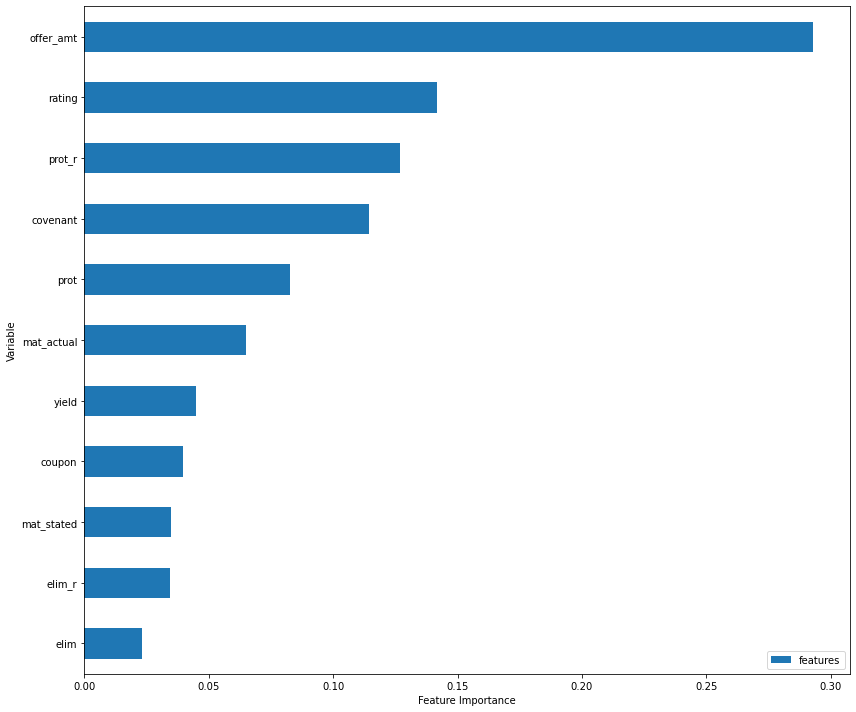

In [59]:
feature_imp = pd.DataFrame(rf_.feature_importances_,index=df.columns[:-1],columns=['features']).sort_values('features')
ax = feature_imp.plot(kind='barh', figsize=(12, 10), zorder=2)
plt.xlabel('Feature Importance')
plt.ylabel('Variable')
plt.tight_layout()
plt.savefig('plot_RF_feature_importance.png', dpi=600, transparent=True)

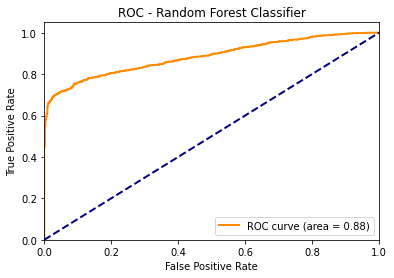

In [65]:
y_score = rf_.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_score[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Random Forest Classifier")
plt.legend(loc="lower right")
plt.savefig('plot_ROC_RandomForest.png', dpi=600, transparent=True)
plt.show()

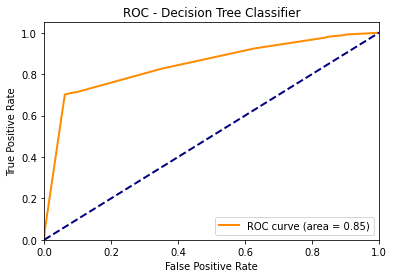

In [66]:
y_score_clf = clf.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score_clf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_score_clf[:, 1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Decision Tree Classifier")
plt.legend(loc="lower right")
plt.savefig('plot_ROC_DecisionTree.png', dpi=600, transparent=True)
plt.show()